<a href="https://colab.research.google.com/github/tobehonest/NNfromScratch/blob/master/Lets_build_MNIST_classifier_from_scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

***Lets Build Neural Network From Scratch***


*   **ReLU** layer (or any other non-linearity you want)
*   **Dense** layer - a fully-connected layer,  f(**X**)=**WX + b** 
*   Loss function - **crossentropy**
*   **Backprop algorithm** - a stochastic gradient descent with backpropageted gradients


In [0]:
import numpy as np

Class : Layer
Functions :
1. Forward - Outputs input
2. Backward - Outputs Gradient


In [0]:
class Layer:
  def __init__(self):
    pass
  def forward(self,input):
    return input
  def backward(self,input,grad):
    
    #Create a diagonal matrix of size input
    n_units = input.shape[1]
    diagonal_input = np.eye(input)
    #Return dot product of grad with input diagonal
    return np.dot(grad,diagonal_input)

Relu Layer:
1. Forward : max(0,input)
2. Backward : grad_relu*grad_output

In [0]:
class ReLu(Layer):
  def __init__(self):
    pass
  def forward(self,input):
    return np.maximum(0,input)
  def backward(self,input,grad_output):
    grad_relu = input > 0
    return grad_relu*grad_output

Dense Layer: 

1.   Forward : weights*input + bias
2.   Backward : grad_input = grad_output*w - return this
                grad_weights = input*grad_output - to find new weights
                weights = wieghts - alpha*grad_weights



In [0]:
class Dense(Layer):
  def __init__(self,input_size,output_size,alpha=0.01):
    self.alpha = alpha
    self.weights = np.random.randn(input_size, output_size)*0.01
    self.bias = np.zeros(output_size)
  def forward(self,input):
    out = np.dot(input,self.weights)
    return out + self.bias
  def backward(self,input,grad_output):
    grad_input = np.dot(grad_output,self.weights.T)
    grad_weight = np.dot(input.T,grad_output)
    grad_biases = grad_output.mean(axis=0)
    
    self.weights = self.weights - self.alpha*grad_weight
    self.bias = self.bias - self.alpha*grad_biases
    return grad_input

In [0]:
def softmax_crossentropy_with_logits(logits,reference_answers):
    """Compute crossentropy from logits[batch,n_classes] and ids of correct answers"""
    logits_for_answers = logits[np.arange(len(logits)),reference_answers]
    
    xentropy = - logits_for_answers + np.log(np.sum(np.exp(logits),axis=-1))
    
    return xentropy

def grad_softmax_crossentropy_with_logits(logits,reference_answers):
    """Compute crossentropy gradient from logits[batch,n_classes] and ids of correct answers"""
    ones_for_answers = np.zeros_like(logits)
    ones_for_answers[np.arange(len(logits)),reference_answers] = 1
    
    softmax = np.exp(logits) / np.exp(logits).sum(axis=-1,keepdims=True)
    
    return (- ones_for_answers + softmax) / logits.shape[0]

In [0]:
def forward(network,X):
  activations = []
  input = X
  for layer in network:
    activations.append(layer.forward(input))
    input = activations[-1]
  return activations

In [0]:
def predict(network,X):
  return forward(network,X)[-1].argmax(axis=-1)

In [0]:
def train_network(network,X,y):
   
    layer_activations = forward(network,X)
    layer_inputs = [X]+layer_activations
    logits = layer_activations[-1]
    loss = softmax_crossentropy_with_logits(logits,y)
    loss_grad = grad_softmax_crossentropy_with_logits(logits,y)
    for layer_i in range(len(network))[::-1]:
        layer = network[layer_i]
        loss_grad = layer.backward(layer_inputs[layer_i],loss_grad) #grad w.r.t. input, also weight updates
        
    return np.mean(loss)

In [438]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [439]:
from tensorflow.examples.tutorials.mnist import input_data
input = input_data.read_data_sets('/content/gdrive/My Drive/DATASETS/mnist')

Extracting /content/gdrive/My Drive/DATASETS/mnist/train-images-idx3-ubyte.gz
Extracting /content/gdrive/My Drive/DATASETS/mnist/train-labels-idx1-ubyte.gz
Extracting /content/gdrive/My Drive/DATASETS/mnist/t10k-images-idx3-ubyte.gz
Extracting /content/gdrive/My Drive/DATASETS/mnist/t10k-labels-idx1-ubyte.gz


In [0]:
train = input.train.images
train_y = input.train.labels

In [0]:
test = input.test.images
test_y = input.test.labels

In [0]:
network = []
network.append(Dense(train.shape[1],100,0.1))
network.append(ReLu())
network.append(Dense(100,200,0.1))
network.append(ReLu())
network.append(Dense(200,10,0.1))

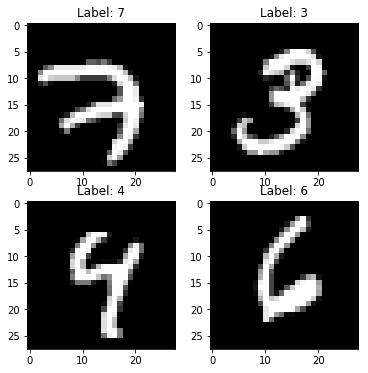

In [443]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=[6,6])
for i in range(4):
    plt.subplot(2,2,i+1)
    plt.title("Label: %i"%train_y[i])
    plt.imshow(train[i].reshape([28,28]),cmap='gray');

In [0]:
train_log = []
val_log = []
for epoch in range(10):
  print("This is epoch {}".format(epoch))
  for x_batch,y_batch in iterate_minibatches(train,train_y,batchsize=500,shuffle=True):
    train_network(network,train,train_y)
    train_log.append(np.mean(predict(network,train)==train_y))
    val_log.append(np.mean(predict(network,test)==test_y))
  print("Epoch",epoch)
  print("Train accuracy:",train_log[-1])
  print("Val accuracy:",val_log[-1])
  plt.plot(train_log,label='train accuracy')
  plt.legend(loc='best')
  plt.plot(val_log,label='val accuracy')
  plt.grid()
  plt.show()
    



This is epoch 0


In [449]:
train.shape
    

(55000, 784)

In [0]:
train.shape

In [0]:
def iterate_minibatches(inputs, targets, batchsize, shuffle=False):
    assert len(inputs) == len(targets)
    if shuffle:
        indices = np.random.permutation(len(inputs))
    for start_idx in range(0, len(inputs) - batchsize + 1, batchsize):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        yield inputs[excerpt], targets[excerpt]